# Bounding Boxes for Cancer Dataset

### Import required libraries

In [20]:
import os
import cv2
import h5py
import glob
import random
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path

## Download the Dataset

#### The *zip* files were obtained in the link https://figshare.com/articles/brain_tumor_dataset/1512427. More information can be found in the reference.

## Read matlab files and organize info in a Pandas Dataframe

Functions to extract matlab files from downloaded zip files and delete them.

In [4]:
def extract_matlab_files(zip_path):
    zip_files = glob.glob(os.path.join(zip_path, '*.zip'))
    for zip_f in zip_files:
        zipfile.ZipFile(zip_f, 'r').extractall(zip_path)
        
def remove_all_matlab_files(mat_files_path):
    files = glob.glob(os.path.join(mat_files_path, '*.mat'))
    list(map(lambda f: os.remove(f), files))

Provide folder path and extract files.

In [5]:
zip_path = Path('../Datasets/MatLab_DS')

extract_matlab_files(zip_path)

Organize each *.mat* file info in a Dataframe row.

In [23]:
def create_dataframe_with_matlab_files(matlab_files_list):

    fields = ['image', 'tumorMask', 'tumorBorder', 'PID', 'label']
    imgs_info = []

    for curr_img in matlab_files_list:
        
        # Read file and get information.
        f = h5py.File(curr_img, 'r')
        image, mask, border, P_id, label = list(map(lambda field: f.get('cjdata/' + field), fields))

        # Tranform all info to numpy.
        image = np.array(image)
        mask = np.array(mask)
        border = np.array(border)
        P_id = "".join([chr(number) for number in np.array(P_id)])
        label = np.array(label)[0][0].astype(np.int16)
        filename = os.path.basename(curr_img)

        imgs_info.append([image, mask, border, P_id, label, filename])
    

    return pd.DataFrame(imgs_info, columns=['Image_Array', 'Mask_Array', 'Tumor_Border', 'Patient_ID', 'Cancer_Type', 'MatLab_File_Name'])
    #print(type(image), type(mask), type(border), type(P_id), type(label))
    #print(image.shape, mask.shape, border.shape, P_id, label)

    """
    return np.array(image), np.array(mask), np.array(border), \
        "".join([chr(number) for number in np.array(P_id)]), \
        np.array(label)[0][0], os.path.basename(matlab_file)
    """

In [25]:
matlab_files_list = glob.glob(os.path.join(zip_path, '*.mat'))

imgs_df = create_dataframe_with_matlab_files(matlab_files_list)
imgs_df.shape

(3064, 6)

Save the dataframe before separation in training and testing. 

In [28]:
imgs_df.to_pickle('dataframe_before_set_separation.pickle')

## Split randomly in train and test sets

In [44]:
train_images = np.random.rand(len(imgs_df)) < 0.90

np.sum(train_images), len(train_images)

(2729, 3064)

In [45]:
imgs_df['Train_Image'] = train_images

In [46]:
imgs_df.head()

,Image_Array,Mask_Array,Tumor_Border,Patient_ID,Cancer_Type,MatLab_File_Name,Train_Image
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[267.0883519862749, 143.97731474260132, 242.7...",MR034694,2,2628.mat,True
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[346.98257839721254, 139.14982578397212, 326....",MR049453,2,1916.mat,True
2,"[[0, 0, 0, 0, 0, 0, 0, 3, 7, 11, 12, 10, 11, 1...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[188.86902810845277, 329.3275833082408, 198.4...",107429,3,1187.mat,True
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[289.2721296743005, 253.11311346501296, 279.9...",113554,1,161.mat,True
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 6, 15, 21, 24, 25, 3...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[272.9477351916376, 274.7317073170732, 270.27...",MR049104,2,2855.mat,True


Save *train* column as numpy.

In [47]:
np.save('train_and_valid_separation.npy', train_images)

## Save images in *train* and *val* folders.

In [ ]:
train_folder =Path(os.path.join('Cheng_Dataset', 'train'))
val_folder = Path(os.path.join('Cheng_Dataset', 'val'))

train_folder.mkdir(parents=True)
val_folder.mkdir(parents=True)

Some tests to see how the images behave when rescaled to 0-255

In [62]:
imgs_df.Image_Array[0].max(), imgs_df.Image_Array[0].min()

(1771, 0)

In [83]:
min_value = imgs_df.Image_Array[0].min()
max_value = imgs_df.Image_Array[0].max()

for img in imgs_df.Image_Array:
    max_value = img.max() if (img.max() > max_value) else max_value
    min_value = img.min() if (img.min() < min_value) else min_value

min_value, max_value

(0, 12728)

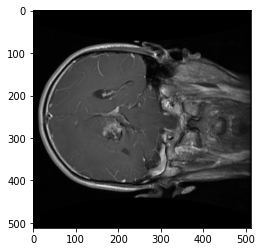

In [54]:
plt.imshow(imgs_df.Image_Array[0], cmap='gray')
plt.show()

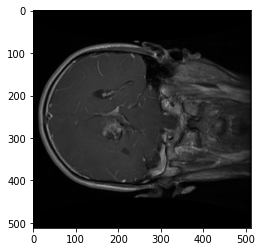

In [85]:
plt.imshow(imgs_df.Image_Array[0], cmap='gray', vmin=0, vmax=2550)
plt.show()

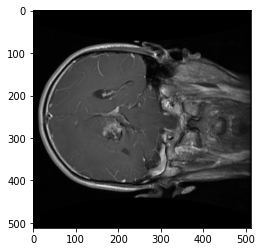

In [90]:
rescaled = imgs_df.Image_Array[0] / imgs_df.Image_Array[0].max()

plt.imshow(rescaled, cmap='gray')
plt.show()

In [92]:
rescaled.max(), rescaled.min()

(1.0, 0.0)

In [93]:
rescaled = (rescaled * 255.0).astype(np.uint8)
rescaled.max(), rescaled.min()

(255, 0)

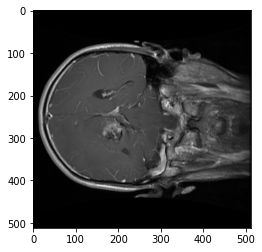

In [95]:
plt.imshow(rescaled, cmap='gray')
plt.show()

The quality is maintained after rescaling process.

In [102]:
type(os.path.splitext(imgs_df.MatLab_File_Name[0])[0])

str

In [105]:
for idx, row in imgs_df.iterrows():
    
    image = row['Image_Array']
    image = image / image.max()
    image = (image * 255.0).astype(np.uint8)

    img_name = os.path.splitext(row['MatLab_File_Name'])[0] + '.png'

    if row['Train_Image']:
        img_path = os.path.join(train_folder, img_name)
    else:
        img_path = os.path.join(val_folder, img_name)   

    pil_image = Image.fromarray(image)
    pil_image.save(img_path)

## Exclude *.mat* files

In [106]:
remove_all_matlab_files(zip_path)